# Review sentiment classification

This notebook analyse hotel reviews from booking.com. We use various models to test their accuracy in prediction of review sentiment (positive or negative reviews)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, log_loss

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('wordnet')

import spacy
from spacy import displacy

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier

import warnings
warnings.filterwarnings("ignore")

tf.get_logger().setLevel('ERROR')

In [2]:
# import the data
reviews_data = pd.read_csv('/Users/israel/Downloads/Hotel_Reviews_Booking.csv')
#reviews_data = reviews_data[:1000]
reviews_data.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


### EDA

##### Present the top 10 nations reviewers are coming from

In [3]:
temp = reviews_data.groupby('Reviewer_Nationality').count()['Reviewer_Score'].reset_index().sort_values(by='Reviewer_Score',ascending=False)
temp[:10].style.background_gradient()

,Reviewer_Nationality,Reviewer_Score
66,United Kingdom,475
68,United States of America,87
25,Ireland,57
2,Australia,39
7,Canada,26
40,Netherlands,21
16,Germany,18
28,Italy,17
15,France,17
27,Israel,16


#### Histogram of reviews length by positive and negative labels

In [4]:
# Count the length of positive and vegative reviews
reviews_data['Num_words_pos'] = reviews_data['Positive_Review'].apply(lambda x:len(str(x).split()))
reviews_data['Num_words_neg'] = reviews_data['Negative_Review'].apply(lambda x:len(str(x).split()))
reviews_data['Num_words_pos_neg_diff'] = reviews_data['Num_words_pos'] - reviews_data['Num_words_neg']

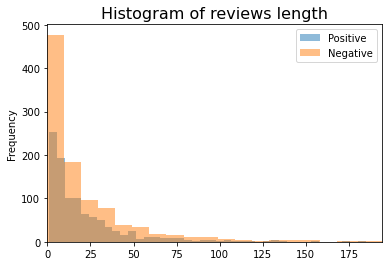

In [5]:
reviews_data['Num_words_pos'].plot.hist(bins=40, alpha=0.5, label='Positive').set_xlim(0,)
reviews_data['Num_words_neg'].plot.hist(bins=40, alpha=0.5, label='Negative')
plt.title('Histogram of reviews length', fontsize=16)
plt.legend()
plt.show()

We have more negative reviews and in general we short reviews are more frequent. Let's have a look at the density:

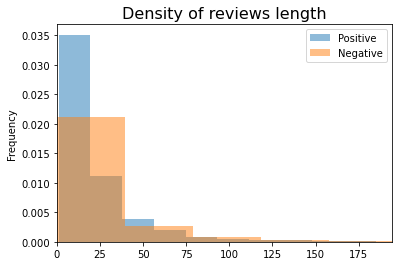

In [6]:
reviews_data['Num_words_pos'].plot.hist(density=True, alpha=0.5, label='Positive').set_xlim(0,)
reviews_data['Num_words_neg'].plot.hist(density=True, alpha=0.5, label='Negative')
plt.title('Density of reviews length', fontsize=16)
plt.legend()
plt.show()

We see that positive reviews are more likely to be short than negative review. It may suggest that positive reviewers are less likely to provide detailed feedback or that they are more concise in their language.

#### Differences in length

The difference between the length of positive and negative reviews can provide insight into the language and style used by reviewers when expressing different sentiments.

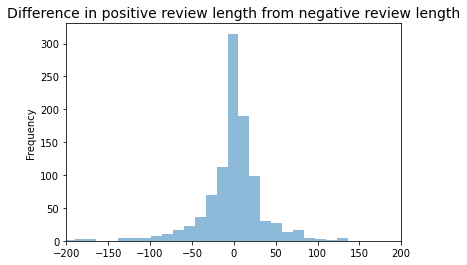

In [7]:
reviews_data['Num_words_pos_neg_diff'].plot.hist(bins=40, alpha=0.5).set_xlim(-200, 200)
plt.title('Difference in positive review length from negative review length', fontsize=14)
plt.show()

#### Named entity recognition (NER)

NER can be used to identify specific aspects of the hotel that are mentioned in the reviews. This can give us a better understanding of what people liked or disliked about the hotel. This is not the focus of this project, but we will examine one positive and one negative review 'to feel' better the data.

In [8]:
nlp = spacy.load('en_core_web_lg')

# Let’s have a look in a positive review for example
text = reviews_data['Positive_Review'][10]
doc = nlp(text)
displacy.render(nlp(doc.text),style='ent', jupyter=True)

In [9]:
# Let’s have a look in a positive review for example
text = reviews_data['Negative_Review'][3]
doc = nlp(text)
displacy.render(nlp(doc.text),style='ent', jupyter=True)

#### Word clouds for positive and negative reviews

Word clouds can be useful for identifying keywords that are commonly associated with positive or negative reviews.

##### Remove stop words

Removing stop words can make it easier to identify the most important words in the word clouds.

In [10]:
sw = stopwords.words('english')
# displaying the stopwords
#np.array(sw)

def stopwords(text):
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

reviews_data['Positive_Review_rsw'] = reviews_data['Positive_Review'].apply(stopwords)
reviews_data['Negative_Review_rsw'] = reviews_data['Negative_Review'].apply(stopwords)
reviews_data.head(5)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,...,Reviewer_Score,Tags,days_since_review,lat,lng,Num_words_pos,Num_words_neg,Num_words_pos_neg_diff,Positive_Review_rsw,Negative_Review_rsw
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,...,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,9,395,-386,park outside hotel beautiful,angry made post available via possible sites u...
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,...,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,103,2,101,real complaints hotel great great location sur...,negative
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,...,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968,19,40,-21,location good staff ok cute hotel breakfast ra...,rooms nice elderly bit difficult rooms two sto...
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,...,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968,24,208,-184,great location nice surroundings bar restauran...,room dirty afraid walk barefoot floor looked c...
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,...,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968,6,138,-132,amazing location building romantic setting,booked company line showed pictures room thoug...


##### Word cloud for positive reviews

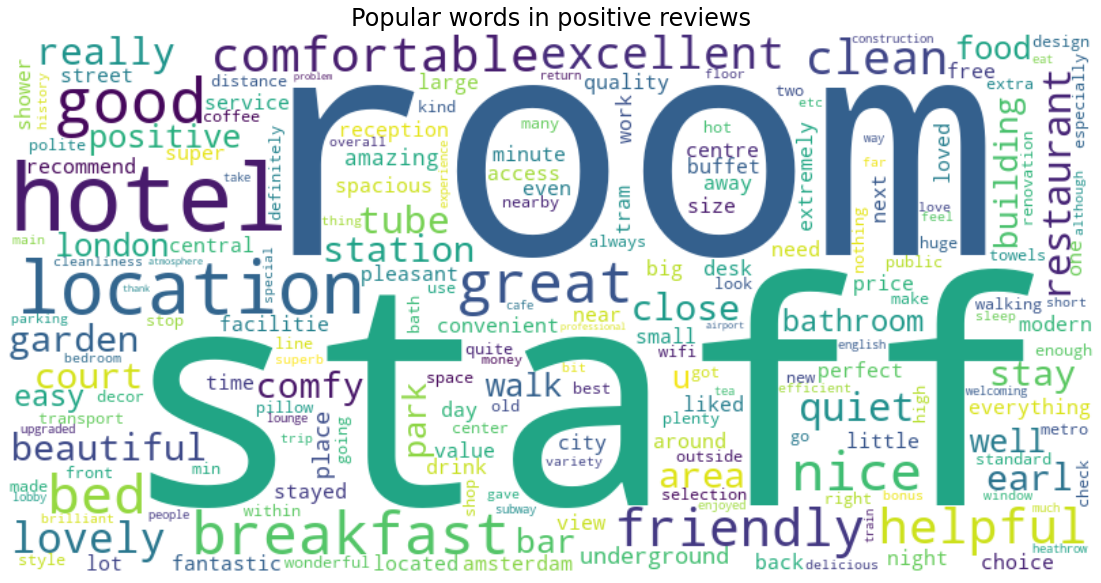

In [11]:
# Creating the text variable
text = " ".join(cat for cat in reviews_data.Positive_Review_rsw)

# Creating word_cloud
word_cloud = WordCloud(collocations = False, background_color = 'white', width=800, height=400).generate(text)

# Display the generated Word Cloud
plt.figure( figsize=(20,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.title('Popular words in positive reviews', fontsize=24)
plt.axis("off")
plt.show()

##### Word cloud for negative reviews

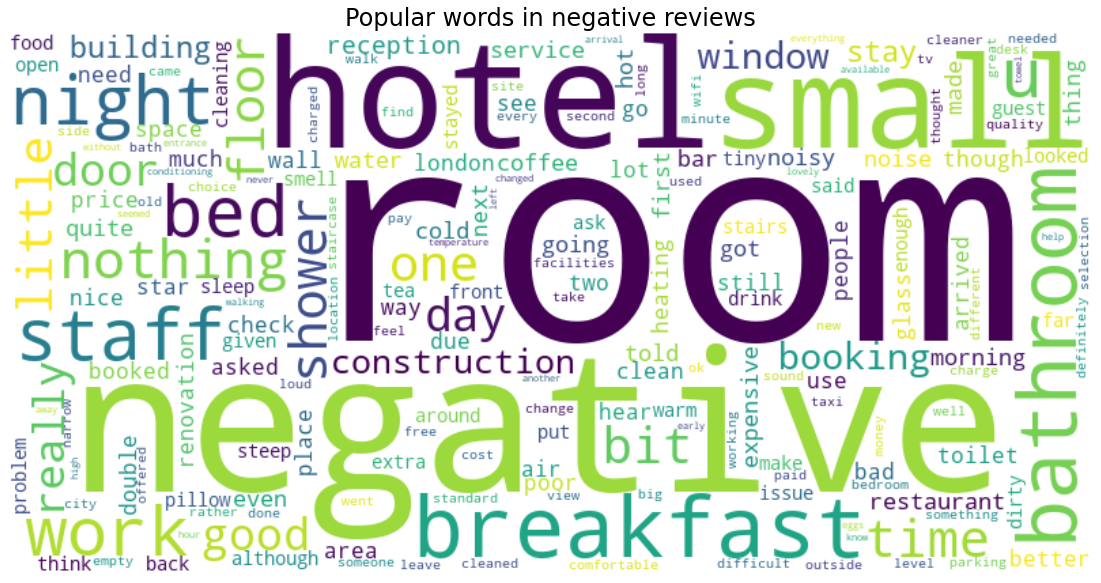

In [12]:
# Creating the text variable
text = " ".join(cat for cat in reviews_data.Negative_Review_rsw)

# Creating word_cloud
word_cloud = WordCloud(collocations = False, background_color = 'white', width=800, height=400).generate(text)

# Display the generated Word Cloud
plt.figure( figsize=(20,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.title('Popular words in negative reviews', fontsize=24)
plt.axis("off")
plt.show()

We see the differences between positive to negative reviews. As both of them mention the 'room' and the 'hotel'. As expected the positive reviews mention positive words like 'good', 'great', 'nice', 'lovely'. The negative reviews mention negative reviews like 'small', 'little', 'noise'.

### Data preparation

In [13]:
### Prepare the reveiws dataset
pos_df = reviews_data[['Positive_Review_rsw']]
pos_df.columns = ['Review']
pos_df['Positive'] = 1

neg_df = reviews_data[['Negative_Review_rsw']]
neg_df.columns = ['Review']
neg_df['Positive'] = 0

clf_df = pd.concat([pos_df,neg_df])
clf_df = clf_df.drop_duplicates().reset_index(drop=True)
clf_df

,Review,Positive
0,park outside hotel beautiful,1
1,real complaints hotel great great location sur...,1
2,location good staff ok cute hotel breakfast ra...,1
3,great location nice surroundings bar restauran...,1
4,amazing location building romantic setting,1
...,...,...
1623,seating bar area would good also trek use toilets,0
1624,cleaner knocked door 8am ideal checking day ne...,0
1625,second time hotel first time booked basic room...,0
1626,going family two rooms hired reservation alloc...,0


In [14]:
# Check for imbalance in the data
clf_df['Positive'].value_counts()

1    919
0    709
Name: Positive, dtype: int64

Here, we assume that the difference is not too big, therefore we will not try to balance the classes.

#### Stemming and lemmatising

In this project we will also exmine the effect of stemming and lemmatization. Both methods can help reduce the dimensionality of the data, that is, the number of variations of words used to express similar sentiments. Thus, these methods can make it easier for the model to learn from the data.

In [15]:
lemmatizer = WordNetLemmatizer()
porter = PorterStemmer()

#tokenization
clf_df['review_token'] = clf_df['Review'].apply(lambda tok: word_tokenize(tok.lower()))
#lemmatizing 
clf_df['lemma_review_token'] = clf_df['review_token'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
#stemming
clf_df['stem_review_token'] = clf_df['review_token'].apply(lambda x: [porter.stem(y) for y in x])
# join the words into sentences
clf_df['Review_lemmatized'] = clf_df['lemma_review_token'].apply(lambda series: ' '.join([word for word in series]))
clf_df['Review_stemmed'] = clf_df['stem_review_token'].apply(lambda series: ' '.join([word for word in series]))
clf_df = clf_df[['Review','Review_lemmatized','Review_stemmed','Positive']]
clf_df

,Review,Review_lemmatized,Review_stemmed,Positive
0,park outside hotel beautiful,park outside hotel beautiful,park outsid hotel beauti,1
1,real complaints hotel great great location sur...,real complaint hotel great great location surr...,real complaint hotel great great locat surroun...,1
2,location good staff ok cute hotel breakfast ra...,location good staff ok cute hotel breakfast ra...,locat good staff ok cute hotel breakfast rang ...,1
3,great location nice surroundings bar restauran...,great location nice surroundings bar restauran...,great locat nice surround bar restaur nice lov...,1
4,amazing location building romantic setting,amazing location building romantic setting,amaz locat build romant set,1
...,...,...,...,...
1623,seating bar area would good also trek use toilets,seating bar area would good also trek use toilet,seat bar area would good also trek use toilet,0
1624,cleaner knocked door 8am ideal checking day ne...,cleaner knocked door 8am ideal checking day ne...,cleaner knock door 8am ideal check day need cl...,0
1625,second time hotel first time booked basic room...,second time hotel first time booked basic room...,second time hotel first time book basic room p...,0
1626,going family two rooms hired reservation alloc...,going family two room hired reservation alloca...,go famili two room hire reserv alloc us two di...,0


We will use both BOW and Tf-idf matrices to compare their performance and see which one works better for our task. This can give us a better understanding of the importance and relevance of different words in the text and how they affect the sentiment of the review.

#### Create BOW matrix

In [16]:
# Extract the tfid representation matrix of the text data (remove numbers)
bow_vectorizer = CountVectorizer(token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
bow_matrix = bow_vectorizer.fit_transform(clf_df['Review'])
# collect the bow matrix in dataframe
bow_df = pd.DataFrame(bow_matrix.todense(), columns= bow_vectorizer.get_feature_names_out())

# BOW for lemmatized and lemmatized text
bow_vectorizer = CountVectorizer(token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
bow_matrix = bow_vectorizer.fit_transform(clf_df['Review_lemmatized'])
lemmatized_bow_df = pd.DataFrame(bow_matrix.todense(), columns= bow_vectorizer.get_feature_names_out())

# BOW for lemmatized and stemmed text
bow_vectorizer = CountVectorizer(token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
bow_matrix = bow_vectorizer.fit_transform(clf_df['Review_stemmed'])
stemmed_bow_df = pd.DataFrame(bow_matrix.todense(), columns= bow_vectorizer.get_feature_names_out())

bow_df

,00pm,10mins,12nn,12pm,15min,15pounds,16th,18th,1990s,1am,...,yes,yesterday,yet,yogurt,young,yrt,z,zero,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1624,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1625,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1626,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Create Tf-idf matrix

In [17]:
# Extract the tfid representation matrix of the text data (remove numbers)
tf_idf_vectorizer = TfidfVectorizer(token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
tf_idf_matrix = tf_idf_vectorizer.fit_transform(clf_df['Review'])
# collect the tfid matrix in dataframe
tf_idf_df = pd.DataFrame(tf_idf_matrix.todense(), columns= tf_idf_vectorizer.get_feature_names_out())

# tfid for lemmatized and lemmatized text
tf_idf_vectorizer = TfidfVectorizer(token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
tf_idf_matrix = tf_idf_vectorizer.fit_transform(clf_df['Review_lemmatized'])
lemmatized_tf_idf_df = pd.DataFrame(tf_idf_matrix.todense(), columns= tf_idf_vectorizer.get_feature_names_out())

# tfid for lemmatized and stemmed text
tf_idf_vectorizer = TfidfVectorizer(token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
tf_idf_matrix = tf_idf_vectorizer.fit_transform(clf_df['Review_stemmed'])
stemmed_tf_idf_df = pd.DataFrame(tf_idf_matrix.todense(), columns= tf_idf_vectorizer.get_feature_names_out())

tf_idf_df

,00pm,10mins,12nn,12pm,15min,15pounds,16th,18th,1990s,1am,...,yes,yesterday,yet,yogurt,young,yrt,z,zero,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


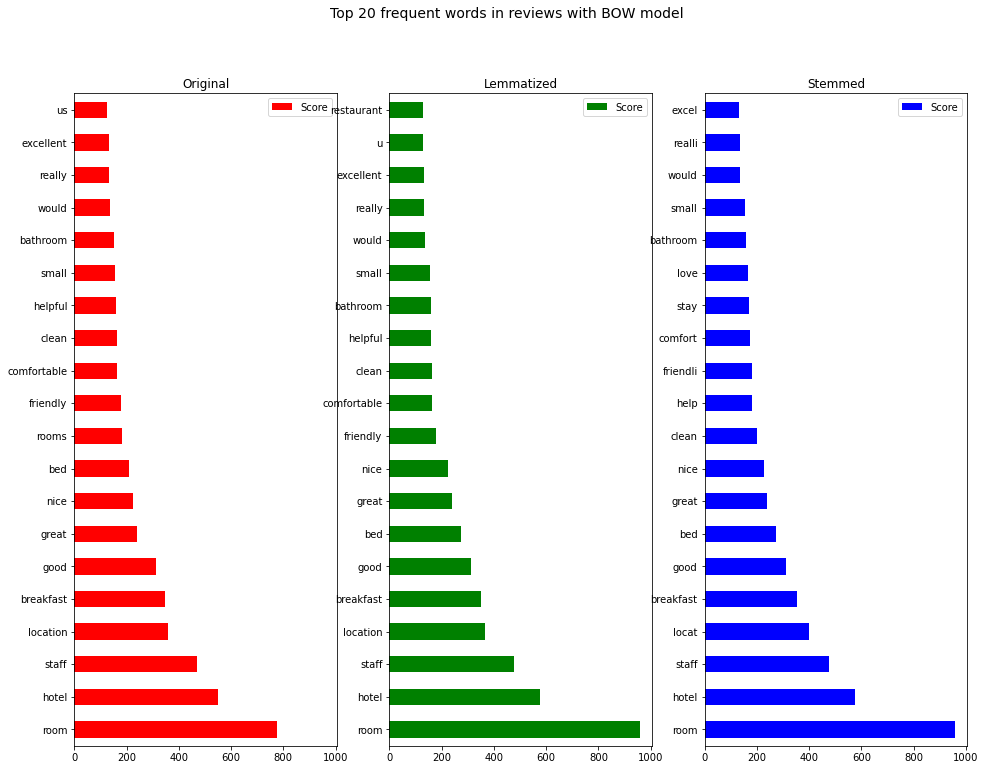

In [18]:
## Show the most important words with BOW
top_vocab_bow = pd.DataFrame(bow_df.sum(), columns=['Score']).sort_values(by=['Score'], ascending=False)
top_lemma_vocab_bow = pd.DataFrame(lemmatized_bow_df.sum(), columns=['Score']).sort_values(by=['Score'], ascending=False)
top_stem_vocab_bow = pd.DataFrame(stemmed_bow_df.sum(), columns=['Score']).sort_values(by=['Score'], ascending=False)


fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, sharex=True, sharey=False, figsize=(16, 12), frameon=False
)
fig.suptitle("Top 20 frequent words in reviews with BOW model", fontsize=14)

top_vocab_bow[:20].plot.barh(ax=ax1, color=['red'])
top_lemma_vocab_bow[:20].plot.barh(ax=ax2, color=['green'])
top_stem_vocab_bow[:20].plot.barh(ax=ax3, color=['blue'])
ax1.title.set_text('Original')
ax2.title.set_text('Lemmatized')
ax3.title.set_text('Stemmed')

plt.show()

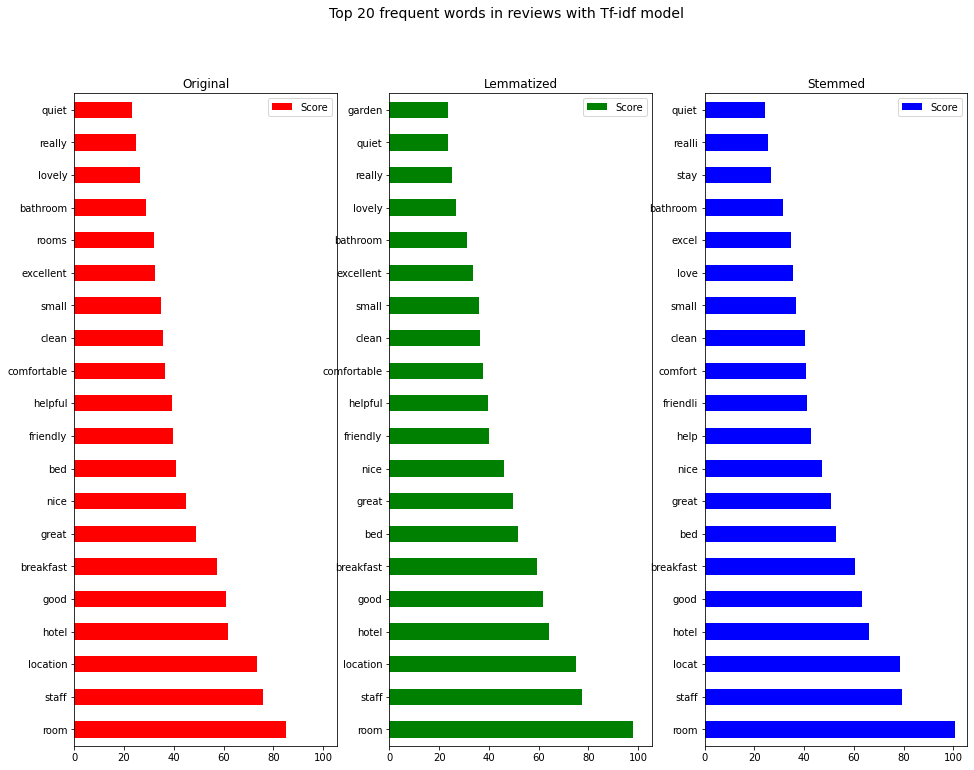

In [19]:
## Show the most important words with Tf-idf
top_vocab_tfidf = pd.DataFrame(tf_idf_df.sum(), columns=['Score']).sort_values(by=['Score'], ascending=False)
top_lemma_vocab_tfidf = pd.DataFrame(lemmatized_tf_idf_df.sum(), columns=['Score']).sort_values(by=['Score'], ascending=False)
top_stem_vocab_tfidf = pd.DataFrame(stemmed_tf_idf_df.sum(), columns=['Score']).sort_values(by=['Score'], ascending=False)


fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, sharex=True, sharey=False, figsize=(16, 12), frameon=False
)
fig.suptitle("Top 20 frequent words in reviews with Tf-idf model", fontsize=14)

top_vocab_tfidf[:20].plot.barh(ax=ax1, color=['red'])
top_lemma_vocab_tfidf[:20].plot.barh(ax=ax2, color=['green'])
top_stem_vocab_tfidf[:20].plot.barh(ax=ax3, color=['blue'])
ax1.title.set_text('Original')
ax2.title.set_text('Lemmatized')
ax3.title.set_text('Stemmed')

plt.show()

Comparing the frequent words we see the similarities and differences between the original, lemmatized and stemmed models.

#### Train - test split

In [20]:
# Assign test data size 25%

##### BOW #####
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_df,clf_df['Positive'],stratify=clf_df['Positive'],test_size= 0.25, random_state=1)
X_train_lemma_bow, X_test_lemma_bow, y_train_lemma_bow, y_test_lemma_bow = train_test_split(lemmatized_bow_df,clf_df['Positive'],stratify=clf_df['Positive'],test_size= 0.25, random_state=1)
X_train_stem_bow, X_test_stem_bow, y_train_stem_bow, y_test_stem_bow = train_test_split(stemmed_bow_df,clf_df['Positive'],stratify=clf_df['Positive'],test_size= 0.25, random_state=1)

##### Tf-idf #####
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(bow_df,clf_df['Positive'],stratify=clf_df['Positive'],test_size= 0.25, random_state=1)
X_train_lemma_tfidf, X_test_lemma_tfidf, y_train_lemma_tfidf, y_test_lemma_tfidf = train_test_split(lemmatized_tf_idf_df,clf_df['Positive'],stratify=clf_df['Positive'],test_size= 0.25, random_state=1)
X_train_stem_tfidf, X_test_stem_tfidf, y_train_stem_tfidf, y_test_stem_tfidf = train_test_split(stemmed_tf_idf_df,clf_df['Positive'],stratify=clf_df['Positive'],test_size= 0.25, random_state=1)

### Training phase

We will create a general function to train various machine learning models by searching for the best parameters for the given classifier using a grid search method using 5-fold cross validation. The function takes in a set of parameters, a classifier, and the training and testing data. 

In [21]:
def model_training(parameter_grid, classifier, X_train, y_train, X_test, y_test):
    
    # gridsearch object using 5 fold cross validation and neg_log_loss as scoring paramter
    gridsearch = GridSearchCV(classifier,parameter_grid, scoring = 'neg_log_loss', cv = 5)
    # fit the gridsearch
    gridsearch.fit(X_train, y_train)
    
    print("Best parameter: ",gridsearch.best_params_)
    # prediction accuracy of the train data
    y_pred = gridsearch.predict(X_test)
    y_pred_proba = gridsearch.predict_proba(X_test)[::,1]
    
    print('Accuracy of best estimator for the test data: ',accuracy_score(y_test, y_pred))
    return y_pred, y_pred_proba, gridsearch.cv_results_

In [22]:
# track models performance
log_models = pd.DataFrame(columns=["Classifier","Morphological analysis","Model","Accuracy","AUC"])

#### Multinomial NB

The alpha hyperparameter in Multinomial NB is a smoothing parameter, which helps to prevent overfitting by adding a small value to the count of each feature to avoid zero probability of features that are not in the training set.

In [23]:
# parameter grid
parameter_grid = [{"alpha": np.linspace(0.001, 10, 100)}]

##### BOW model

Original text: 
Best parameter:  {'alpha': 3.233}
Accuracy of best estimator for the test data:  0.8918918918918919

 Lemmatized text: 
Best parameter:  {'alpha': 3.132}
Accuracy of best estimator for the test data:  0.8918918918918919

 Stemmed text: 
Best parameter:  {'alpha': 3.637}
Accuracy of best estimator for the test data:  0.8968058968058968


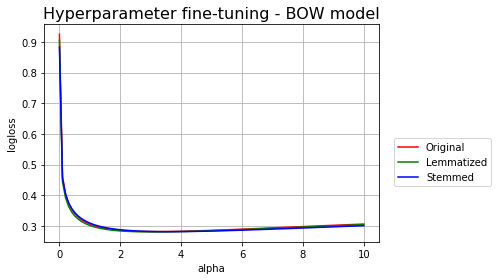

In [24]:
print('Original text: ')
y_pred_bow, y_pred_proba_bow, cv_results_bow = model_training(parameter_grid, MultinomialNB(), X_train_bow, y_train_bow, X_test_bow, y_test_bow)
print('\n Lemmatized text: ')
y_pred_lemma_bow, y_pred_proba_lemma_bow, cv_results_lemma_bow = model_training(parameter_grid, MultinomialNB(), X_train_lemma_bow, y_train_lemma_bow, X_test_lemma_bow, y_test_lemma_bow)
print('\n Stemmed text: ')
y_pred_stem_bow, y_pred_proba_stem_bow, cv_results_stem_bow = model_training(parameter_grid, MultinomialNB(), X_train_stem_bow, y_train_stem_bow, X_test_stem_bow, y_test_stem_bow)

plt.plot(cv_results_bow['param_alpha'], -cv_results_bow['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_bow['param_alpha'], -cv_results_lemma_bow['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_bow['param_alpha'], -cv_results_stem_bow['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('alpha')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - BOW model', fontsize=16)
plt.grid()

##### Tf-idf model

Original text: 
Best parameter:  {'alpha': 3.233}
Accuracy of best estimator for the test data:  0.8918918918918919

 Lemmatized text: 
Best parameter:  {'alpha': 0.10200000000000001}
Accuracy of best estimator for the test data:  0.8943488943488943

 Stemmed text: 
Best parameter:  {'alpha': 0.10200000000000001}
Accuracy of best estimator for the test data:  0.8894348894348895


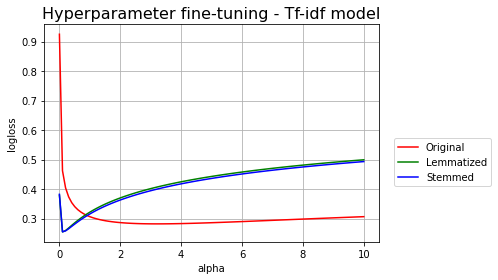

In [25]:
print('Original text: ')
y_pred_tfidf, y_pred_proba_tfidf, cv_results_tfidf = model_training(parameter_grid, MultinomialNB(), X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)
print('\n Lemmatized text: ')
y_pred_lemma_tfidf, y_pred_proba_lemma_tfidf, cv_results_lemma_tfidf = model_training(parameter_grid, MultinomialNB(), X_train_lemma_tfidf, y_train_lemma_tfidf, X_test_lemma_tfidf, y_test_lemma_tfidf)
print('\n Stemmed text: ')
y_pred_stem_tfidf, y_pred_proba_stem_tfidf, cv_results_stem_tfidf = model_training(parameter_grid, MultinomialNB(), X_train_stem_tfidf, y_train_stem_tfidf, X_test_stem_tfidf, y_test_stem_tfidf)

plt.plot(cv_results_tfidf['param_alpha'], -cv_results_tfidf['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_tfidf['param_alpha'], -cv_results_lemma_tfidf['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_tfidf['param_alpha'], -cv_results_stem_tfidf['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('alpha')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - Tf-idf model', fontsize=16)
plt.grid()

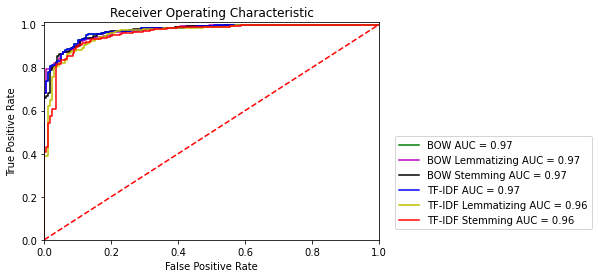

In [26]:
## ROC curve

#bow
fpr_bow, tpr_bow, threshold = metrics.roc_curve(y_test_bow, y_pred_proba_bow)
roc_auc_bow = metrics.auc(fpr_bow, tpr_bow)
fpr_lemma_bow, tpr_lemma_bow, threshold = metrics.roc_curve(y_test_lemma_bow, y_pred_proba_lemma_bow)
roc_auc_lemma_bow = metrics.auc(fpr_lemma_bow, tpr_lemma_bow)
fpr_stem_bow, tpr_stem_bow, threshold = metrics.roc_curve(y_test_stem_bow, y_pred_proba_stem_bow)
roc_auc_stem_bow = metrics.auc(fpr_stem_bow, tpr_stem_bow)

#tfidf
fpr_tfidf, tpr_tfidf, threshold = metrics.roc_curve(y_test_tfidf, y_pred_proba_tfidf)
roc_auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)
fpr_lemma_tfidf, tpr_lemma_tfidf, threshold = metrics.roc_curve(y_test_lemma_tfidf, y_pred_proba_lemma_tfidf)
roc_auc_lemma_tfidf = metrics.auc(fpr_lemma_tfidf, tpr_lemma_tfidf)
fpr_stem_tfidf, tpr_stem_tfidf, threshold = metrics.roc_curve(y_test_stem_tfidf, y_pred_proba_stem_tfidf)
roc_auc_stem_tfidf = metrics.auc(fpr_stem_tfidf, tpr_stem_tfidf)

# plotting
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_bow, tpr_bow, 'g', label = 'BOW AUC = %0.2f' % roc_auc_bow)
plt.plot(fpr_lemma_bow, tpr_lemma_bow, 'm', label = 'BOW Lemmatizing AUC = %0.2f' % roc_auc_lemma_bow)
plt.plot(fpr_stem_bow, tpr_stem_bow, 'k', label = 'BOW Stemming AUC = %0.2f' % roc_auc_stem_bow)
plt.plot(fpr_tfidf, tpr_tfidf, 'b', label = 'TF-IDF AUC = %0.2f' % roc_auc_tfidf)
plt.plot(fpr_lemma_tfidf, tpr_lemma_tfidf, 'y', label = 'TF-IDF Lemmatizing AUC = %0.2f' % roc_auc_lemma_tfidf)
plt.plot(fpr_stem_tfidf, tpr_stem_tfidf, 'r', label = 'TF-IDF Stemming AUC = %0.2f' % roc_auc_stem_tfidf)
plt.legend(bbox_to_anchor=(1.65, 0.5))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [27]:
log_models.loc[len(log_models)] = ['Multinomial NB','Original','BOW',accuracy_score(y_test_bow, y_pred_bow),roc_auc_bow]
log_models.loc[len(log_models)] = ['Multinomial NB','Lemmatizing','BOW',accuracy_score(y_test_lemma_bow, y_pred_lemma_bow),roc_auc_lemma_bow]
log_models.loc[len(log_models)] = ['Multinomial NB','Stemming','BOW',accuracy_score(y_test_stem_bow, y_pred_stem_bow),roc_auc_stem_bow]
log_models.loc[len(log_models)] = ['Multinomial NB','Original','TF-IDF',accuracy_score(y_test_tfidf, y_pred_tfidf),roc_auc_tfidf]
log_models.loc[len(log_models)] = ['Multinomial NB','Lemmatizing','TF-IDF',accuracy_score(y_test_lemma_tfidf, y_pred_lemma_tfidf),roc_auc_lemma_tfidf]
log_models.loc[len(log_models)] = ['Multinomial NB','Stemming','TF-IDF',accuracy_score(y_test_stem_tfidf, y_pred_stem_tfidf),roc_auc_stem_tfidf]

#### Bernoulli NB

In [28]:
# parameter grid
parameter_grid = [{"alpha": np.linspace(0.001, 10, 100)}]

##### BOW model

Original text: 
Best parameter:  {'alpha': 0.30400000000000005}
Accuracy of best estimator for the test data:  0.8402948402948403

 Lemmatized text: 
Best parameter:  {'alpha': 0.30400000000000005}
Accuracy of best estimator for the test data:  0.8452088452088452

 Stemmed text: 
Best parameter:  {'alpha': 0.405}
Accuracy of best estimator for the test data:  0.8476658476658476


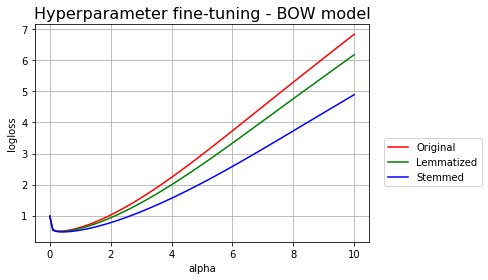

In [29]:
print('Original text: ')
y_pred_bow, y_pred_proba_bow, cv_results_bow = model_training(parameter_grid, BernoulliNB(), X_train_bow, y_train_bow, X_test_bow, y_test_bow)
print('\n Lemmatized text: ')
y_pred_lemma_bow, y_pred_proba_lemma_bow, cv_results_lemma_bow = model_training(parameter_grid, BernoulliNB(), X_train_lemma_bow, y_train_lemma_bow, X_test_lemma_bow, y_test_lemma_bow)
print('\n Stemmed text: ')
y_pred_stem_bow, y_pred_proba_stem_bow, cv_results_stem_bow = model_training(parameter_grid, BernoulliNB(), X_train_stem_bow, y_train_stem_bow, X_test_stem_bow, y_test_stem_bow)

plt.plot(cv_results_bow['param_alpha'], -cv_results_bow['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_bow['param_alpha'], -cv_results_lemma_bow['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_bow['param_alpha'], -cv_results_stem_bow['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('alpha')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - BOW model', fontsize=16)
plt.grid()

##### Tf-idf model

Original text: 
Best parameter:  {'alpha': 0.30400000000000005}
Accuracy of best estimator for the test data:  0.8402948402948403

 Lemmatized text: 
Best parameter:  {'alpha': 0.30400000000000005}
Accuracy of best estimator for the test data:  0.8452088452088452

 Stemmed text: 
Best parameter:  {'alpha': 0.405}
Accuracy of best estimator for the test data:  0.8476658476658476


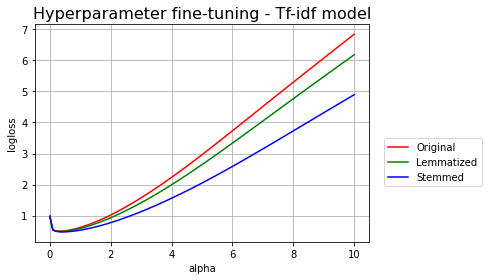

In [30]:
print('Original text: ')
y_pred_tfidf, y_pred_proba_tfidf, cv_results_tfidf = model_training(parameter_grid, BernoulliNB(), X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)
print('\n Lemmatized text: ')
y_pred_lemma_tfidf, y_pred_proba_lemma_tfidf, cv_results_lemma_tfidf = model_training(parameter_grid, BernoulliNB(), X_train_lemma_tfidf, y_train_lemma_tfidf, X_test_lemma_tfidf, y_test_lemma_tfidf)
print('\n Stemmed text: ')
y_pred_stem_tfidf, y_pred_proba_stem_tfidf, cv_results_stem_tfidf = model_training(parameter_grid, BernoulliNB(), X_train_stem_tfidf, y_train_stem_tfidf, X_test_stem_tfidf, y_test_stem_tfidf)

plt.plot(cv_results_tfidf['param_alpha'], -cv_results_tfidf['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_tfidf['param_alpha'], -cv_results_lemma_tfidf['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_tfidf['param_alpha'], -cv_results_stem_tfidf['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('alpha')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - Tf-idf model', fontsize=16)
plt.grid()

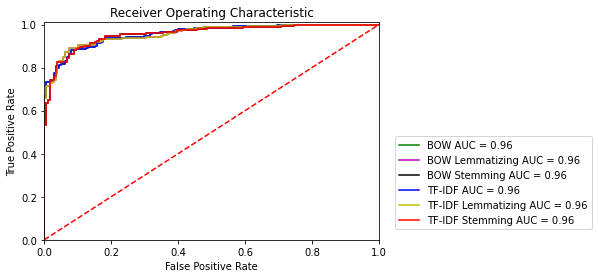

In [31]:
## ROC curve

#bow
fpr_bow, tpr_bow, threshold = metrics.roc_curve(y_test_bow, y_pred_proba_bow)
roc_auc_bow = metrics.auc(fpr_bow, tpr_bow)
fpr_lemma_bow, tpr_lemma_bow, threshold = metrics.roc_curve(y_test_lemma_bow, y_pred_proba_lemma_bow)
roc_auc_lemma_bow = metrics.auc(fpr_lemma_bow, tpr_lemma_bow)
fpr_stem_bow, tpr_stem_bow, threshold = metrics.roc_curve(y_test_stem_bow, y_pred_proba_stem_bow)
roc_auc_stem_bow = metrics.auc(fpr_stem_bow, tpr_stem_bow)

#tfidf
fpr_tfidf, tpr_tfidf, threshold = metrics.roc_curve(y_test_tfidf, y_pred_proba_tfidf)
roc_auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)
fpr_lemma_tfidf, tpr_lemma_tfidf, threshold = metrics.roc_curve(y_test_lemma_tfidf, y_pred_proba_lemma_tfidf)
roc_auc_lemma_tfidf = metrics.auc(fpr_lemma_tfidf, tpr_lemma_tfidf)
fpr_stem_tfidf, tpr_stem_tfidf, threshold = metrics.roc_curve(y_test_stem_tfidf, y_pred_proba_stem_tfidf)
roc_auc_stem_tfidf = metrics.auc(fpr_stem_tfidf, tpr_stem_tfidf)

# plotting
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_bow, tpr_bow, 'g', label = 'BOW AUC = %0.2f' % roc_auc_bow)
plt.plot(fpr_lemma_bow, tpr_lemma_bow, 'm', label = 'BOW Lemmatizing AUC = %0.2f' % roc_auc_lemma_bow)
plt.plot(fpr_stem_bow, tpr_stem_bow, 'k', label = 'BOW Stemming AUC = %0.2f' % roc_auc_stem_bow)
plt.plot(fpr_tfidf, tpr_tfidf, 'b', label = 'TF-IDF AUC = %0.2f' % roc_auc_tfidf)
plt.plot(fpr_lemma_tfidf, tpr_lemma_tfidf, 'y', label = 'TF-IDF Lemmatizing AUC = %0.2f' % roc_auc_lemma_tfidf)
plt.plot(fpr_stem_tfidf, tpr_stem_tfidf, 'r', label = 'TF-IDF Stemming AUC = %0.2f' % roc_auc_stem_tfidf)
plt.legend(bbox_to_anchor=(1.65, 0.5))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [32]:
log_models.loc[len(log_models)] = ['Bernoulli NB','Original','BOW',accuracy_score(y_test_bow, y_pred_bow),roc_auc_bow]
log_models.loc[len(log_models)] = ['Bernoulli NB','Lemmatizing','BOW',accuracy_score(y_test_lemma_bow, y_pred_lemma_bow),roc_auc_lemma_bow]
log_models.loc[len(log_models)] = ['Bernoulli NB','Stemming','BOW',accuracy_score(y_test_stem_bow, y_pred_stem_bow),roc_auc_stem_bow]
log_models.loc[len(log_models)] = ['Bernoulli NB','Original','TF-IDF',accuracy_score(y_test_tfidf, y_pred_tfidf),roc_auc_tfidf]
log_models.loc[len(log_models)] = ['Bernoulli NB','Lemmatizing','TF-IDF',accuracy_score(y_test_lemma_tfidf, y_pred_lemma_tfidf),roc_auc_lemma_tfidf]
log_models.loc[len(log_models)] = ['Bernoulli NB','Stemming','TF-IDF',accuracy_score(y_test_stem_tfidf, y_pred_stem_tfidf),roc_auc_stem_tfidf]

Bernoulli NB assumes that all the features are binary such that they take only two values: 0 represent that word does not occur in the text and 1 as word occurs in the text. Where as Multinomial NB cares about counts for multiple features that do occur and it is use with the count of each word to predict the label.

For these reasons we see that the multinomial NB works better with our data.

#### SVM

The gamma parameter defines how flexible our model is. A small gamma value means that the model is trying to fit the training data as best as possible, while a large gamma value means the model is trying to be more simple and general.

In [33]:
# parameter grid
parameter_grid = [{'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}]

##### BOW model

Original text: 
Best parameter:  {'gamma': 0.01, 'kernel': 'rbf'}
Accuracy of best estimator for the test data:  0.8771498771498771

 Lemmatized text: 
Best parameter:  {'gamma': 0.01, 'kernel': 'rbf'}
Accuracy of best estimator for the test data:  0.8796068796068796

 Stemmed text: 
Best parameter:  {'gamma': 0.01, 'kernel': 'rbf'}
Accuracy of best estimator for the test data:  0.8943488943488943


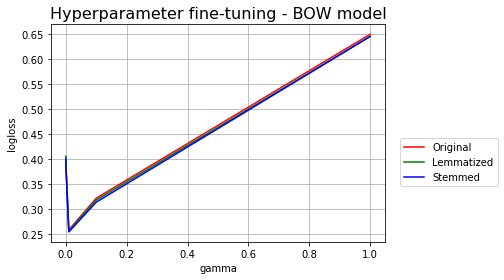

In [34]:
print('Original text: ')
y_pred_bow, y_pred_proba_bow, cv_results_bow = model_training(parameter_grid, SVC(probability=True), X_train_bow, y_train_bow, X_test_bow, y_test_bow)
print('\n Lemmatized text: ')
y_pred_lemma_bow, y_pred_proba_lemma_bow, cv_results_lemma_bow = model_training(parameter_grid, SVC(probability=True), X_train_lemma_bow, y_train_lemma_bow, X_test_lemma_bow, y_test_lemma_bow)
print('\n Stemmed text: ')
y_pred_stem_bow, y_pred_proba_stem_bow, cv_results_stem_bow = model_training(parameter_grid, SVC(probability=True), X_train_stem_bow, y_train_stem_bow, X_test_stem_bow, y_test_stem_bow)

plt.plot(cv_results_bow['param_gamma'], -cv_results_bow['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_bow['param_gamma'], -cv_results_lemma_bow['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_bow['param_gamma'], -cv_results_stem_bow['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('gamma')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - BOW model', fontsize=16)
plt.grid()

##### Tf-idf model

Original text: 
Best parameter:  {'gamma': 0.01, 'kernel': 'rbf'}
Accuracy of best estimator for the test data:  0.8771498771498771

 Lemmatized text: 
Best parameter:  {'gamma': 1, 'kernel': 'rbf'}
Accuracy of best estimator for the test data:  0.9115479115479116

 Stemmed text: 
Best parameter:  {'gamma': 1, 'kernel': 'rbf'}
Accuracy of best estimator for the test data:  0.9213759213759214


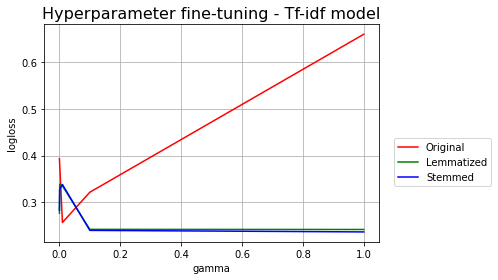

In [35]:
print('Original text: ')
y_pred_tfidf, y_pred_proba_tfidf, cv_results_tfidf = model_training(parameter_grid, SVC(probability=True), X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)
print('\n Lemmatized text: ')
y_pred_lemma_tfidf, y_pred_proba_lemma_tfidf, cv_results_lemma_tfidf = model_training(parameter_grid, SVC(probability=True), X_train_lemma_tfidf, y_train_lemma_tfidf, X_test_lemma_tfidf, y_test_lemma_tfidf)
print('\n Stemmed text: ')
y_pred_stem_tfidf, y_pred_proba_stem_tfidf, cv_results_stem_tfidf = model_training(parameter_grid, SVC(probability=True), X_train_stem_tfidf, y_train_stem_tfidf, X_test_stem_tfidf, y_test_stem_tfidf)

plt.plot(cv_results_tfidf['param_gamma'], -cv_results_tfidf['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_tfidf['param_gamma'], -cv_results_lemma_tfidf['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_tfidf['param_gamma'], -cv_results_stem_tfidf['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('gamma')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - Tf-idf model', fontsize=16)
plt.grid()

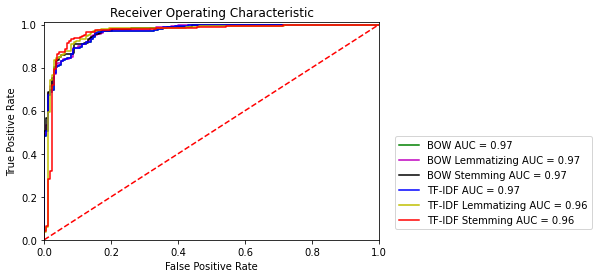

In [36]:
## ROC curve

#bow
fpr_bow, tpr_bow, threshold = metrics.roc_curve(y_test_bow, y_pred_proba_bow)
roc_auc_bow = metrics.auc(fpr_bow, tpr_bow)
fpr_lemma_bow, tpr_lemma_bow, threshold = metrics.roc_curve(y_test_lemma_bow, y_pred_proba_lemma_bow)
roc_auc_lemma_bow = metrics.auc(fpr_lemma_bow, tpr_lemma_bow)
fpr_stem_bow, tpr_stem_bow, threshold = metrics.roc_curve(y_test_stem_bow, y_pred_proba_stem_bow)
roc_auc_stem_bow = metrics.auc(fpr_stem_bow, tpr_stem_bow)

#tfidf
fpr_tfidf, tpr_tfidf, threshold = metrics.roc_curve(y_test_tfidf, y_pred_proba_tfidf)
roc_auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)
fpr_lemma_tfidf, tpr_lemma_tfidf, threshold = metrics.roc_curve(y_test_lemma_tfidf, y_pred_proba_lemma_tfidf)
roc_auc_lemma_tfidf = metrics.auc(fpr_lemma_tfidf, tpr_lemma_tfidf)
fpr_stem_tfidf, tpr_stem_tfidf, threshold = metrics.roc_curve(y_test_stem_tfidf, y_pred_proba_stem_tfidf)
roc_auc_stem_tfidf = metrics.auc(fpr_stem_tfidf, tpr_stem_tfidf)

# plotting
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_bow, tpr_bow, 'g', label = 'BOW AUC = %0.2f' % roc_auc_bow)
plt.plot(fpr_lemma_bow, tpr_lemma_bow, 'm', label = 'BOW Lemmatizing AUC = %0.2f' % roc_auc_lemma_bow)
plt.plot(fpr_stem_bow, tpr_stem_bow, 'k', label = 'BOW Stemming AUC = %0.2f' % roc_auc_stem_bow)
plt.plot(fpr_tfidf, tpr_tfidf, 'b', label = 'TF-IDF AUC = %0.2f' % roc_auc_tfidf)
plt.plot(fpr_lemma_tfidf, tpr_lemma_tfidf, 'y', label = 'TF-IDF Lemmatizing AUC = %0.2f' % roc_auc_lemma_tfidf)
plt.plot(fpr_stem_tfidf, tpr_stem_tfidf, 'r', label = 'TF-IDF Stemming AUC = %0.2f' % roc_auc_stem_tfidf)
plt.legend(bbox_to_anchor=(1.65, 0.5))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [37]:
log_models.loc[len(log_models)] = ['SVM','Original','BOW',accuracy_score(y_test_bow, y_pred_bow),roc_auc_bow]
log_models.loc[len(log_models)] = ['SVM','Lemmatizing','BOW',accuracy_score(y_test_lemma_bow, y_pred_lemma_bow),roc_auc_lemma_bow]
log_models.loc[len(log_models)] = ['SVM','Stemming','BOW',accuracy_score(y_test_stem_bow, y_pred_stem_bow),roc_auc_stem_bow]
log_models.loc[len(log_models)] = ['SVM','Original','TF-IDF',accuracy_score(y_test_tfidf, y_pred_tfidf),roc_auc_tfidf]
log_models.loc[len(log_models)] = ['SVM','Lemmatizing','TF-IDF',accuracy_score(y_test_lemma_tfidf, y_pred_lemma_tfidf),roc_auc_lemma_tfidf]
log_models.loc[len(log_models)] = ['SVM','Stemming','TF-IDF',accuracy_score(y_test_stem_tfidf, y_pred_stem_tfidf),roc_auc_stem_tfidf]

#### Decision Tree Classifier

In [38]:
# parameter grid
parameter_grid = [{'max_depth':[2,3,4,5,6,7,8,9,10,11,12,15,20]}]

##### BOW model

Original text: 
Best parameter:  {'max_depth': 2}
Accuracy of best estimator for the test data:  0.7493857493857494

 Lemmatized text: 
Best parameter:  {'max_depth': 2}
Accuracy of best estimator for the test data:  0.7493857493857494

 Stemmed text: 
Best parameter:  {'max_depth': 2}
Accuracy of best estimator for the test data:  0.7518427518427518


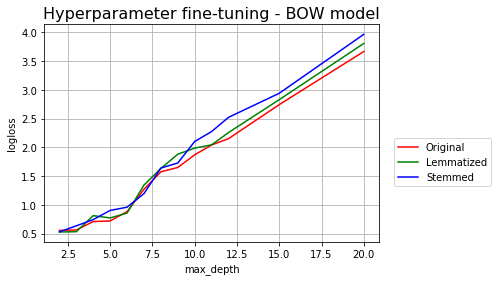

In [39]:
print('Original text: ')
y_pred_bow, y_pred_proba_bow, cv_results_bow = model_training(parameter_grid, DecisionTreeClassifier(), X_train_bow, y_train_bow, X_test_bow, y_test_bow)
print('\n Lemmatized text: ')
y_pred_lemma_bow, y_pred_proba_lemma_bow, cv_results_lemma_bow = model_training(parameter_grid, DecisionTreeClassifier(), X_train_lemma_bow, y_train_lemma_bow, X_test_lemma_bow, y_test_lemma_bow)
print('\n Stemmed text: ')
y_pred_stem_bow, y_pred_proba_stem_bow, cv_results_stem_bow = model_training(parameter_grid, DecisionTreeClassifier(), X_train_stem_bow, y_train_stem_bow, X_test_stem_bow, y_test_stem_bow)

plt.plot(cv_results_bow['param_max_depth'], -cv_results_bow['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_bow['param_max_depth'], -cv_results_lemma_bow['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_bow['param_max_depth'], -cv_results_stem_bow['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('max_depth')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - BOW model', fontsize=16)
plt.grid()

##### Tf-idf model

Original text: 
Best parameter:  {'max_depth': 2}
Accuracy of best estimator for the test data:  0.7493857493857494

 Lemmatized text: 
Best parameter:  {'max_depth': 2}
Accuracy of best estimator for the test data:  0.7567567567567568

 Stemmed text: 
Best parameter:  {'max_depth': 2}
Accuracy of best estimator for the test data:  0.7567567567567568


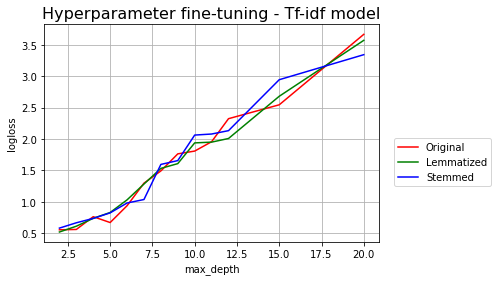

In [40]:
print('Original text: ')
y_pred_tfidf, y_pred_proba_tfidf, cv_results_tfidf = model_training(parameter_grid, DecisionTreeClassifier(), X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)
print('\n Lemmatized text: ')
y_pred_lemma_tfidf, y_pred_proba_lemma_tfidf, cv_results_lemma_tfidf = model_training(parameter_grid, DecisionTreeClassifier(), X_train_lemma_tfidf, y_train_lemma_tfidf, X_test_lemma_tfidf, y_test_lemma_tfidf)
print('\n Stemmed text: ')
y_pred_stem_tfidf, y_pred_proba_stem_tfidf, cv_results_stem_tfidf = model_training(parameter_grid, DecisionTreeClassifier(), X_train_stem_tfidf, y_train_stem_tfidf, X_test_stem_tfidf, y_test_stem_tfidf)

plt.plot(cv_results_tfidf['param_max_depth'], -cv_results_tfidf['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_tfidf['param_max_depth'], -cv_results_lemma_tfidf['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_tfidf['param_max_depth'], -cv_results_stem_tfidf['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('max_depth')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - Tf-idf model', fontsize=16)
plt.grid()

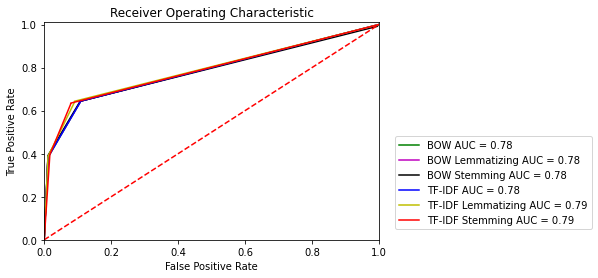

In [41]:
## ROC curve

#bow
fpr_bow, tpr_bow, threshold = metrics.roc_curve(y_test_bow, y_pred_proba_bow)
roc_auc_bow = metrics.auc(fpr_bow, tpr_bow)
fpr_lemma_bow, tpr_lemma_bow, threshold = metrics.roc_curve(y_test_lemma_bow, y_pred_proba_lemma_bow)
roc_auc_lemma_bow = metrics.auc(fpr_lemma_bow, tpr_lemma_bow)
fpr_stem_bow, tpr_stem_bow, threshold = metrics.roc_curve(y_test_stem_bow, y_pred_proba_stem_bow)
roc_auc_stem_bow = metrics.auc(fpr_stem_bow, tpr_stem_bow)

#tfidf
fpr_tfidf, tpr_tfidf, threshold = metrics.roc_curve(y_test_tfidf, y_pred_proba_tfidf)
roc_auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)
fpr_lemma_tfidf, tpr_lemma_tfidf, threshold = metrics.roc_curve(y_test_lemma_tfidf, y_pred_proba_lemma_tfidf)
roc_auc_lemma_tfidf = metrics.auc(fpr_lemma_tfidf, tpr_lemma_tfidf)
fpr_stem_tfidf, tpr_stem_tfidf, threshold = metrics.roc_curve(y_test_stem_tfidf, y_pred_proba_stem_tfidf)
roc_auc_stem_tfidf = metrics.auc(fpr_stem_tfidf, tpr_stem_tfidf)

# plotting
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_bow, tpr_bow, 'g', label = 'BOW AUC = %0.2f' % roc_auc_bow)
plt.plot(fpr_lemma_bow, tpr_lemma_bow, 'm', label = 'BOW Lemmatizing AUC = %0.2f' % roc_auc_lemma_bow)
plt.plot(fpr_stem_bow, tpr_stem_bow, 'k', label = 'BOW Stemming AUC = %0.2f' % roc_auc_stem_bow)
plt.plot(fpr_tfidf, tpr_tfidf, 'b', label = 'TF-IDF AUC = %0.2f' % roc_auc_tfidf)
plt.plot(fpr_lemma_tfidf, tpr_lemma_tfidf, 'y', label = 'TF-IDF Lemmatizing AUC = %0.2f' % roc_auc_lemma_tfidf)
plt.plot(fpr_stem_tfidf, tpr_stem_tfidf, 'r', label = 'TF-IDF Stemming AUC = %0.2f' % roc_auc_stem_tfidf)
plt.legend(bbox_to_anchor=(1.65, 0.5))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [42]:
log_models.loc[len(log_models)] = ['Decision Tree Classifier','Original','BOW',accuracy_score(y_test_bow, y_pred_bow),roc_auc_bow]
log_models.loc[len(log_models)] = ['Decision Tree Classifier','Lemmatizing','BOW',accuracy_score(y_test_lemma_bow, y_pred_lemma_bow),roc_auc_lemma_bow]
log_models.loc[len(log_models)] = ['Decision Tree Classifier','Stemming','BOW',accuracy_score(y_test_stem_bow, y_pred_stem_bow),roc_auc_stem_bow]
log_models.loc[len(log_models)] = ['Decision Tree Classifier','Original','TF-IDF',accuracy_score(y_test_tfidf, y_pred_tfidf),roc_auc_tfidf]
log_models.loc[len(log_models)] = ['Decision Tree Classifier','Lemmatizing','TF-IDF',accuracy_score(y_test_lemma_tfidf, y_pred_lemma_tfidf),roc_auc_lemma_tfidf]
log_models.loc[len(log_models)] = ['Decision Tree Classifier','Stemming','TF-IDF',accuracy_score(y_test_stem_tfidf, y_pred_stem_tfidf),roc_auc_stem_tfidf]

#### K-Neighbors Classifier

In [43]:
# parameter grid
parameter_grid = [{'n_neighbors':list(range(1, 21))}]

##### BOW model

Original text: 
Best parameter:  {'n_neighbors': 14}
Accuracy of best estimator for the test data:  0.8083538083538083

 Lemmatized text: 
Best parameter:  {'n_neighbors': 16}
Accuracy of best estimator for the test data:  0.8329238329238329

 Stemmed text: 
Best parameter:  {'n_neighbors': 20}
Accuracy of best estimator for the test data:  0.828009828009828


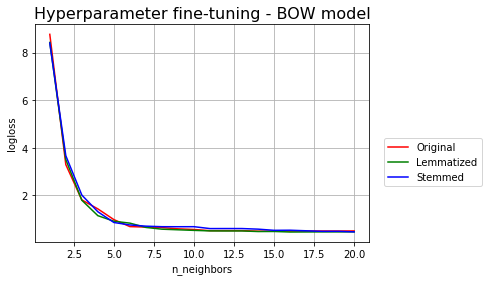

In [44]:
print('Original text: ')
y_pred_bow, y_pred_proba_bow, cv_results_bow = model_training(parameter_grid, KNeighborsClassifier(), X_train_bow, y_train_bow, X_test_bow, y_test_bow)
print('\n Lemmatized text: ')
y_pred_lemma_bow, y_pred_proba_lemma_bow, cv_results_lemma_bow = model_training(parameter_grid, KNeighborsClassifier(), X_train_lemma_bow, y_train_lemma_bow, X_test_lemma_bow, y_test_lemma_bow)
print('\n Stemmed text: ')
y_pred_stem_bow, y_pred_proba_stem_bow, cv_results_stem_bow = model_training(parameter_grid, KNeighborsClassifier(), X_train_stem_bow, y_train_stem_bow, X_test_stem_bow, y_test_stem_bow)

plt.plot(cv_results_bow['param_n_neighbors'], -cv_results_bow['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_bow['param_n_neighbors'], -cv_results_lemma_bow['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_bow['param_n_neighbors'], -cv_results_stem_bow['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('n_neighbors')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - BOW model', fontsize=16)
plt.grid()

##### Tf-idf model

Original text: 
Best parameter:  {'n_neighbors': 14}
Accuracy of best estimator for the test data:  0.8083538083538083

 Lemmatized text: 
Best parameter:  {'n_neighbors': 18}
Accuracy of best estimator for the test data:  0.8746928746928747

 Stemmed text: 
Best parameter:  {'n_neighbors': 19}
Accuracy of best estimator for the test data:  0.8722358722358723


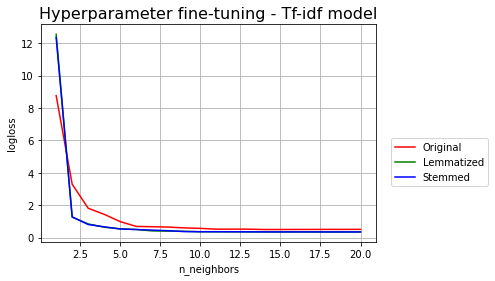

In [45]:
print('Original text: ')
y_pred_tfidf, y_pred_proba_tfidf, cv_results_tfidf = model_training(parameter_grid, KNeighborsClassifier(), X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)
print('\n Lemmatized text: ')
y_pred_lemma_tfidf, y_pred_proba_lemma_tfidf, cv_results_lemma_tfidf = model_training(parameter_grid, KNeighborsClassifier(), X_train_lemma_tfidf, y_train_lemma_tfidf, X_test_lemma_tfidf, y_test_lemma_tfidf)
print('\n Stemmed text: ')
y_pred_stem_tfidf, y_pred_proba_stem_tfidf, cv_results_stem_tfidf = model_training(parameter_grid, KNeighborsClassifier(), X_train_stem_tfidf, y_train_stem_tfidf, X_test_stem_tfidf, y_test_stem_tfidf)

plt.plot(cv_results_tfidf['param_n_neighbors'], -cv_results_tfidf['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_tfidf['param_n_neighbors'], -cv_results_lemma_tfidf['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_tfidf['param_n_neighbors'], -cv_results_stem_tfidf['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('n_neighbors')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - Tf-idf model', fontsize=16)
plt.grid()

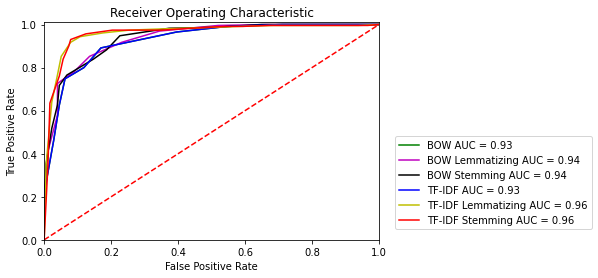

In [46]:
## ROC curve

#bow
fpr_bow, tpr_bow, threshold = metrics.roc_curve(y_test_bow, y_pred_proba_bow)
roc_auc_bow = metrics.auc(fpr_bow, tpr_bow)
fpr_lemma_bow, tpr_lemma_bow, threshold = metrics.roc_curve(y_test_lemma_bow, y_pred_proba_lemma_bow)
roc_auc_lemma_bow = metrics.auc(fpr_lemma_bow, tpr_lemma_bow)
fpr_stem_bow, tpr_stem_bow, threshold = metrics.roc_curve(y_test_stem_bow, y_pred_proba_stem_bow)
roc_auc_stem_bow = metrics.auc(fpr_stem_bow, tpr_stem_bow)

#tfidf
fpr_tfidf, tpr_tfidf, threshold = metrics.roc_curve(y_test_tfidf, y_pred_proba_tfidf)
roc_auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)
fpr_lemma_tfidf, tpr_lemma_tfidf, threshold = metrics.roc_curve(y_test_lemma_tfidf, y_pred_proba_lemma_tfidf)
roc_auc_lemma_tfidf = metrics.auc(fpr_lemma_tfidf, tpr_lemma_tfidf)
fpr_stem_tfidf, tpr_stem_tfidf, threshold = metrics.roc_curve(y_test_stem_tfidf, y_pred_proba_stem_tfidf)
roc_auc_stem_tfidf = metrics.auc(fpr_stem_tfidf, tpr_stem_tfidf)

# plotting
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_bow, tpr_bow, 'g', label = 'BOW AUC = %0.2f' % roc_auc_bow)
plt.plot(fpr_lemma_bow, tpr_lemma_bow, 'm', label = 'BOW Lemmatizing AUC = %0.2f' % roc_auc_lemma_bow)
plt.plot(fpr_stem_bow, tpr_stem_bow, 'k', label = 'BOW Stemming AUC = %0.2f' % roc_auc_stem_bow)
plt.plot(fpr_tfidf, tpr_tfidf, 'b', label = 'TF-IDF AUC = %0.2f' % roc_auc_tfidf)
plt.plot(fpr_lemma_tfidf, tpr_lemma_tfidf, 'y', label = 'TF-IDF Lemmatizing AUC = %0.2f' % roc_auc_lemma_tfidf)
plt.plot(fpr_stem_tfidf, tpr_stem_tfidf, 'r', label = 'TF-IDF Stemming AUC = %0.2f' % roc_auc_stem_tfidf)
plt.legend(bbox_to_anchor=(1.65, 0.5))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
log_models.loc[len(log_models)] = ['K-Neighbors Classifier','Original','BOW',accuracy_score(y_test_bow, y_pred_bow),roc_auc_bow]
log_models.loc[len(log_models)] = ['K-Neighbors Classifier','Lemmatizing','BOW',accuracy_score(y_test_lemma_bow, y_pred_lemma_bow),roc_auc_lemma_bow]
log_models.loc[len(log_models)] = ['K-Neighbors Classifier','Stemming','BOW',accuracy_score(y_test_stem_bow, y_pred_stem_bow),roc_auc_stem_bow]
log_models.loc[len(log_models)] = ['K-Neighbors Classifier','Original','TF-IDF',accuracy_score(y_test_tfidf, y_pred_tfidf),roc_auc_tfidf]
log_models.loc[len(log_models)] = ['K-Neighbors Classifier','Lemmatizing','TF-IDF',accuracy_score(y_test_lemma_tfidf, y_pred_lemma_tfidf),roc_auc_lemma_tfidf]
log_models.loc[len(log_models)] = ['K-Neighbors Classifier','Stemming','TF-IDF',accuracy_score(y_test_stem_tfidf, y_pred_stem_tfidf),roc_auc_stem_tfidf]

#### ANN

In [48]:
# parameter grid
#parameter_grid = [{'batch_size':[10, 20, 40, 60, 80, 100], 'epochs':[1,3,5,10, 30, 50]}]
parameter_grid = [{'batch_size':[10, 20, 40, 60, 80, 100]}]

In [49]:
def ANNModel(n_features):
    # create model
    model = Sequential()
    model.add(Dense(20, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
    model.add(Dense(12, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

##### BOW model

Original text: 


2022-09-13 16:48:03.156819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Best parameter:  {'batch_size': 10}
Accuracy of best estimator for the test data:  0.8820638820638821

 Lemmatized text: 
Best parameter:  {'batch_size': 10}
Accuracy of best estimator for the test data:  0.8894348894348895

 Stemmed text: 
Best parameter:  {'batch_size': 10}
Accuracy of best estimator for the test data:  0.8894348894348895


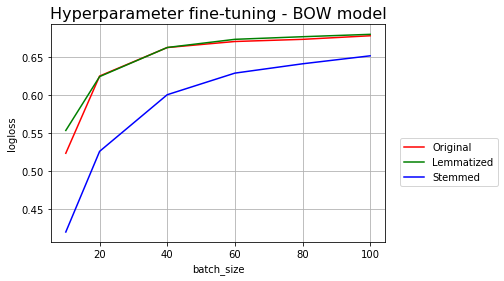

In [58]:
print('Original text: ')
ANNClassifier = KerasClassifier(model=ANNModel(n_features=X_train_bow.shape[1]), verbose=0)
y_pred_bow, y_pred_proba_bow, cv_results_bow = model_training(parameter_grid, ANNClassifier, X_train_bow, y_train_bow, X_test_bow, y_test_bow)
print('\n Lemmatized text: ')
ANNClassifier = KerasClassifier(model=ANNModel(n_features=X_train_lemma_bow.shape[1]), verbose=0)
y_pred_lemma_bow, y_pred_proba_lemma_bow, cv_results_lemma_bow = model_training(parameter_grid, ANNClassifier, X_train_lemma_bow, y_train_lemma_bow, X_test_lemma_bow, y_test_lemma_bow)
print('\n Stemmed text: ')
ANNClassifier = KerasClassifier(model=ANNModel(n_features=X_train_stem_bow.shape[1]), verbose=0)
y_pred_stem_bow, y_pred_proba_stem_bow, cv_results_stem_bow = model_training(parameter_grid, ANNClassifier, X_train_stem_bow, y_train_stem_bow, X_test_stem_bow, y_test_stem_bow)

plt.plot(cv_results_bow['param_batch_size'], -cv_results_bow['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_bow['param_batch_size'], -cv_results_lemma_bow['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_bow['param_batch_size'], -cv_results_stem_bow['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('batch_size')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - BOW model', fontsize=16)
plt.grid()

##### Tf-idf model

Original text: 
Best parameter:  {'batch_size': 10}
Accuracy of best estimator for the test data:  0.8845208845208845

 Lemmatized text: 
Best parameter:  {'batch_size': 10}
Accuracy of best estimator for the test data:  0.8722358722358723

 Stemmed text: 
Best parameter:  {'batch_size': 10}
Accuracy of best estimator for the test data:  0.683046683046683


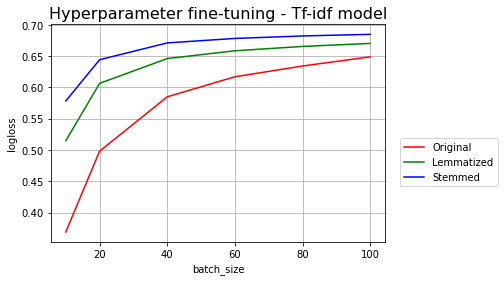

In [59]:
print('Original text: ')
ANNClassifier = KerasClassifier(model=ANNModel(n_features=X_train_tfidf.shape[1]), verbose=0)
y_pred_tfidf, y_pred_proba_tfidf, cv_results_tfidf = model_training(parameter_grid, ANNClassifier, X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf)
print('\n Lemmatized text: ')
ANNClassifier = KerasClassifier(model=ANNModel(n_features=X_train_lemma_tfidf.shape[1]), verbose=0)
y_pred_lemma_tfidf, y_pred_proba_lemma_tfidf, cv_results_lemma_tfidf = model_training(parameter_grid, ANNClassifier, X_train_lemma_tfidf, y_train_lemma_tfidf, X_test_lemma_tfidf, y_test_lemma_tfidf)
print('\n Stemmed text: ')
ANNClassifier = KerasClassifier(model=ANNModel(n_features=X_train_stem_tfidf.shape[1]), verbose=0)
y_pred_stem_tfidf, y_pred_proba_stem_tfidf, cv_results_stem_tfidf = model_training(parameter_grid, ANNClassifier, X_train_stem_tfidf, y_train_stem_tfidf, X_test_stem_tfidf, y_test_stem_tfidf)

plt.plot(cv_results_tfidf['param_batch_size'], -cv_results_tfidf['mean_test_score'], label='Original', color="red")
plt.plot(cv_results_lemma_tfidf['param_batch_size'], -cv_results_lemma_tfidf['mean_test_score'], label='Lemmatized', color="green")
plt.plot(cv_results_stem_tfidf['param_batch_size'], -cv_results_stem_tfidf['mean_test_score'], label='Stemmed', color="blue")
plt.xlabel('batch_size')
plt.ylabel('logloss')
plt.legend(bbox_to_anchor=(1.35, 0.5))
plt.title('Hyperparameter fine-tuning - Tf-idf model', fontsize=16)
plt.grid()

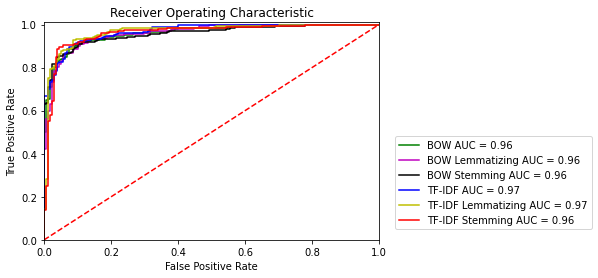

In [60]:
## ROC curve

#bow
fpr_bow, tpr_bow, threshold = metrics.roc_curve(y_test_bow, y_pred_proba_bow)
roc_auc_bow = metrics.auc(fpr_bow, tpr_bow)
fpr_lemma_bow, tpr_lemma_bow, threshold = metrics.roc_curve(y_test_lemma_bow, y_pred_proba_lemma_bow)
roc_auc_lemma_bow = metrics.auc(fpr_lemma_bow, tpr_lemma_bow)
fpr_stem_bow, tpr_stem_bow, threshold = metrics.roc_curve(y_test_stem_bow, y_pred_proba_stem_bow)
roc_auc_stem_bow = metrics.auc(fpr_stem_bow, tpr_stem_bow)

#tfidf
fpr_tfidf, tpr_tfidf, threshold = metrics.roc_curve(y_test_tfidf, y_pred_proba_tfidf)
roc_auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)
fpr_lemma_tfidf, tpr_lemma_tfidf, threshold = metrics.roc_curve(y_test_lemma_tfidf, y_pred_proba_lemma_tfidf)
roc_auc_lemma_tfidf = metrics.auc(fpr_lemma_tfidf, tpr_lemma_tfidf)
fpr_stem_tfidf, tpr_stem_tfidf, threshold = metrics.roc_curve(y_test_stem_tfidf, y_pred_proba_stem_tfidf)
roc_auc_stem_tfidf = metrics.auc(fpr_stem_tfidf, tpr_stem_tfidf)

# plotting
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_bow, tpr_bow, 'g', label = 'BOW AUC = %0.2f' % roc_auc_bow)
plt.plot(fpr_lemma_bow, tpr_lemma_bow, 'm', label = 'BOW Lemmatizing AUC = %0.2f' % roc_auc_lemma_bow)
plt.plot(fpr_stem_bow, tpr_stem_bow, 'k', label = 'BOW Stemming AUC = %0.2f' % roc_auc_stem_bow)
plt.plot(fpr_tfidf, tpr_tfidf, 'b', label = 'TF-IDF AUC = %0.2f' % roc_auc_tfidf)
plt.plot(fpr_lemma_tfidf, tpr_lemma_tfidf, 'y', label = 'TF-IDF Lemmatizing AUC = %0.2f' % roc_auc_lemma_tfidf)
plt.plot(fpr_stem_tfidf, tpr_stem_tfidf, 'r', label = 'TF-IDF Stemming AUC = %0.2f' % roc_auc_stem_tfidf)
plt.legend(bbox_to_anchor=(1.65, 0.5))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [61]:
log_models.loc[len(log_models)] = ['ANN','Original','BOW',accuracy_score(y_test_bow, y_pred_bow),roc_auc_bow]
log_models.loc[len(log_models)] = ['ANN','Lemmatizing','BOW',accuracy_score(y_test_lemma_bow, y_pred_lemma_bow),roc_auc_lemma_bow]
log_models.loc[len(log_models)] = ['ANN','Stemming','BOW',accuracy_score(y_test_stem_bow, y_pred_stem_bow),roc_auc_stem_bow]
log_models.loc[len(log_models)] = ['ANN','Original','TF-IDF',accuracy_score(y_test_tfidf, y_pred_tfidf),roc_auc_tfidf]
log_models.loc[len(log_models)] = ['ANN','Lemmatizing','TF-IDF',accuracy_score(y_test_lemma_tfidf, y_pred_lemma_tfidf),roc_auc_lemma_tfidf]
log_models.loc[len(log_models)] = ['ANN','Stemming','TF-IDF',accuracy_score(y_test_stem_tfidf, y_pred_stem_tfidf),roc_auc_stem_tfidf]

### Model selection

In [62]:
# Present accuracy and AUC of all the models
log_models.sort_values(by="Accuracy",ascending=False)

,Classifier,morphological analysis,Model,Accuracy,AUC
17,SVM,Stemming,TF-IDF,0.921376,0.960255
16,SVM,Lemmatizing,TF-IDF,0.901720,0.966200
2,Multinomial NB,Stemming,BOW,0.896806,0.970671
14,SVM,Stemming,BOW,0.894349,0.968976
4,Multinomial NB,Lemmatizing,TF-IDF,0.894349,0.959789
1,Multinomial NB,Lemmatizing,BOW,0.891892,0.970818
0,Multinomial NB,Original,BOW,0.891892,0.972341
3,Multinomial NB,Original,TF-IDF,0.891892,0.972341
32,ANN,Stemming,BOW,0.889435,0.957087
31,ANN,Lemmatizing,BOW,0.889435,0.959519


In [63]:
# Sort the data by the AUC
log_models.sort_values(by="AUC",ascending=False)

,Classifier,morphological analysis,Model,Accuracy,AUC
0,Multinomial NB,Original,BOW,0.891892,0.972341
3,Multinomial NB,Original,TF-IDF,0.891892,0.972341
1,Multinomial NB,Lemmatizing,BOW,0.891892,0.970818
2,Multinomial NB,Stemming,BOW,0.896806,0.970671
14,SVM,Stemming,BOW,0.894349,0.968976
13,SVM,Lemmatizing,BOW,0.879607,0.967526
33,ANN,Original,TF-IDF,0.884521,0.967060
16,SVM,Lemmatizing,TF-IDF,0.901720,0.966200
34,ANN,Lemmatizing,TF-IDF,0.872236,0.965954
12,SVM,Original,BOW,0.877150,0.965340


We see that Multinomial NB and SVM models works better with our data. The performance of the secision tree classifier is low compared to the rest. Using BOW or Tf-idf doesn't change significantly the accuracy. We also do not see significant better performance with stemming or lemmatizing analysis.

Since our data is slightly unbalanced and AUC is a good metric when the classes are imbalanced, we will use Multinomial NB without stemming or lemmatizing the text data.